In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import defaultdict

In [20]:
def merge_data():
    filenames = ['test_sparse_matrix_gpu_sizes128-1024-4096.json', 'test_sparse_matrix_gpu_sizes8192.json']
    dict_f1 = None
    dict_f2 = None
    with open('test_sparse_matrix_gpu_sizes128-1024-4096.json', 'r') as fp:
        dict_f1 = json.load(fp)
    with open('test_sparse_matrix_gpu_sizes8192.json', 'r') as fp:
        dict_f2 = json.load(fp)

    dict_results = {key_func: {key_t: defaultdict(dict) for key_t in dict_f1[key_func].keys()} for key_func in dict_f1.keys()}
    for dic in [dict_f1, dict_f2]:
        for key_func, vals_func in dic.items():
            for key_t, vals_t in vals_func.items():
                for key_size, vals_size in vals_t.items():
                    dict_results[key_func][key_t].update(vals_t)
    with open('test_sparse_matrix_gpu_sizes128-1024-4096-8192.json', 'w') as fp:
        json.dump(dict_results, fp, indent=2)

In [21]:
dict_results = None
filename = 'test_sparse_matrix_gpu_sizes128-1024-4096-8192.json'
with open(filename, 'r') as fp:
    dict_results = json.load(fp)

In [22]:
for key, itms in dict_results.items():
    mean = np.mean(list(map(float, itms['dense_tensor']['8192'].values())))*1000
    print(key, mean, 'ms')

torch_mm 126.117528057346 ms
torch_matmul 127.41511021418 ms
torch_sparse_mm 127.84398779316832 ms


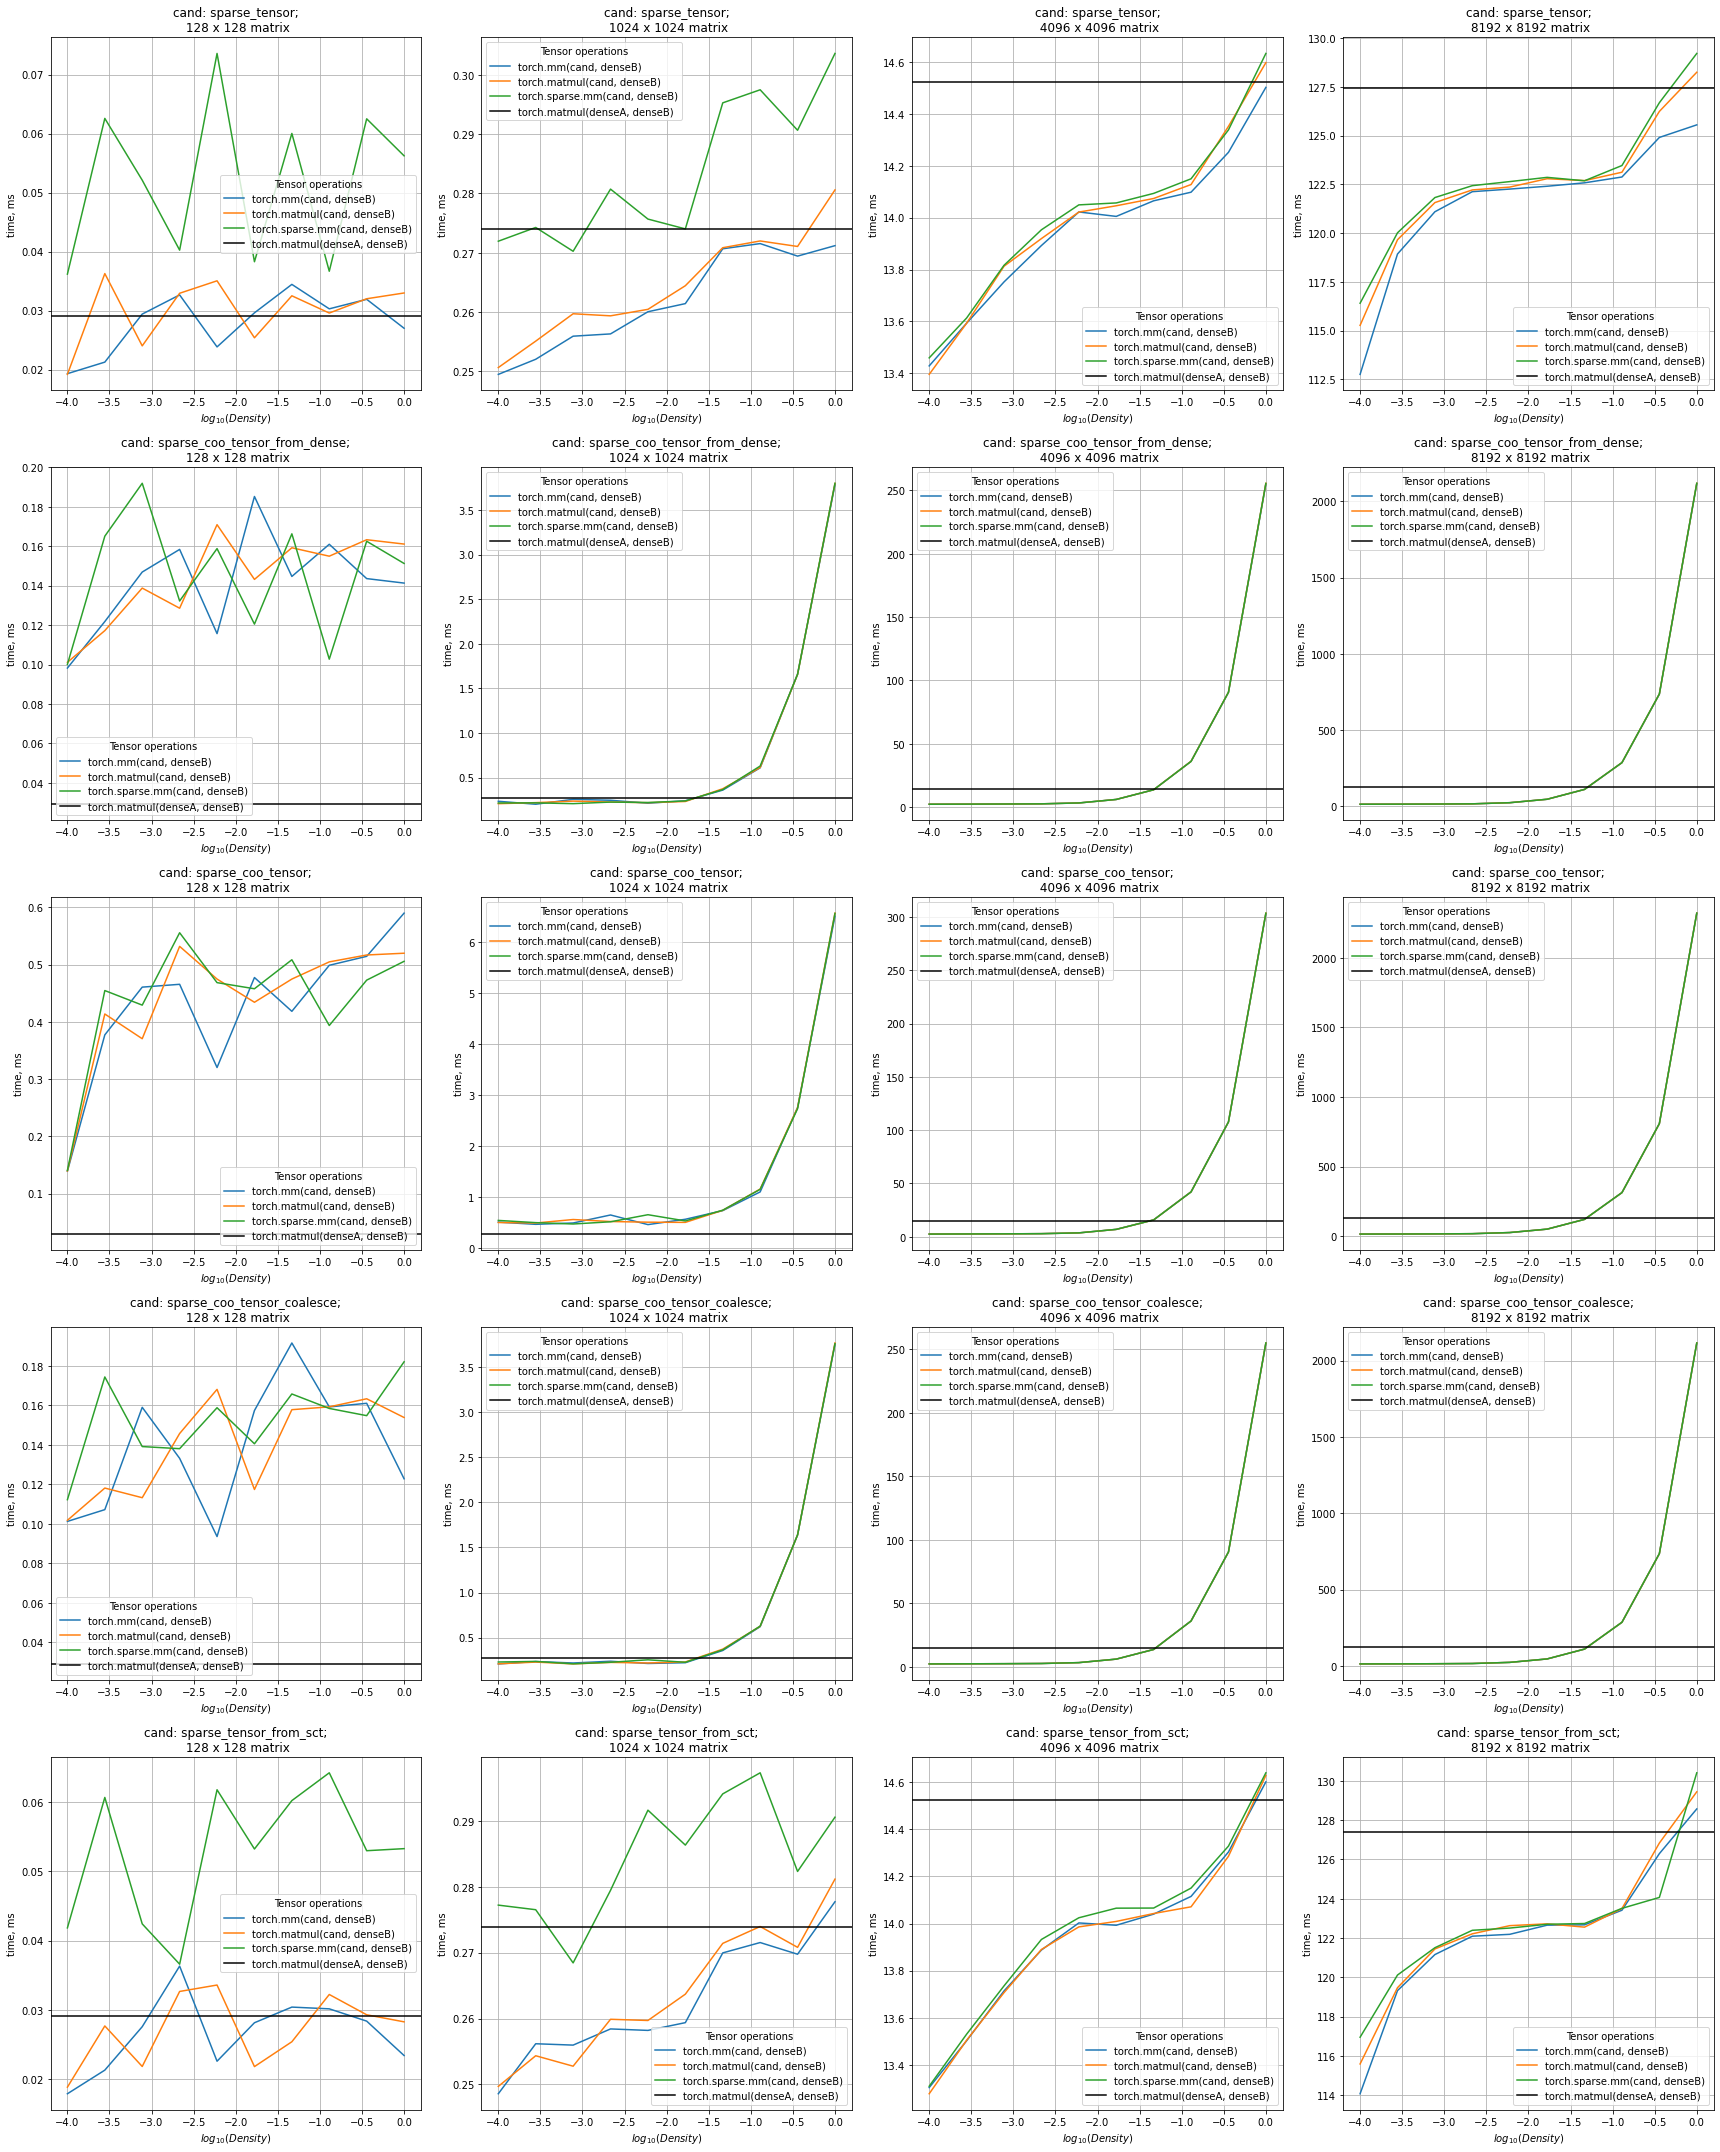

In [65]:
def _plot_comp_tensormethods_vs_sizes_across_tensorops(dict_results):
    tensor_ops = list(dict_results.keys())
    tensor_methods = list(dict_results[tensor_ops[0]].keys())
    sizes = list(dict_results[tensor_ops[0]][tensor_methods[0]].keys())
    densities = list(dict_results[tensor_ops[0]][tensor_methods[0]][sizes[0]].keys())
    
    ref_op = 'torch_matmul'
    ref_method = 'dense_tensor'
    tensor_methods.remove(ref_method)

    nrows, ncols = len(tensor_methods), len(sizes) + (1 if len(sizes) == 1 else 0)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*6, nrows*6))

    for r, method in enumerate(tensor_methods):
        for c, size in enumerate(sorted(list(map(int, sizes)))):
            size = str(size)
            xvals = np.log10(list(map(float, densities)))
            
            for op in tensor_ops:
                yvals = np.array(list(map(float, dict_results[op][method][size].values())))
                # yvals = (ref_vals / yvals - 1) * 100
                yvals = yvals * 1000
                axes[r][c].plot(xvals, yvals, label=f"{'.'.join(op.split('_'))}(cand, denseB)")
            
            ref_time = np.mean(list(dict_results[ref_op][ref_method][size].values())) * 1000
            axes[r][c].axline((xvals[0], ref_time), (xvals[1], ref_time), color='k', label="torch.matmul(denseA, denseB)")
            # axes[r][c].text(x=xvals[1], y=ref_time*1.001, s=f"torch.matmul(denseA, denseB)")
            
            axes[r][c].legend(title='Tensor operations')
            axes[r][c].set_title(f'cand: {method};\n {size} x {size} matrix')
            axes[r][c].set_xlabel(r'$log_{10}(Density)$')
            axes[r][c].set_ylabel(f'time, ms')
            axes[r][c].grid()
    plt.tight_layout()
    return fig, axes
    
fig, axes = _plot_comp_tensormethods_vs_sizes_across_tensorops(dict_results)
fig.savefig(f'{filename.split(".")[0]}_methods_vs_sizes_across_ops.png')

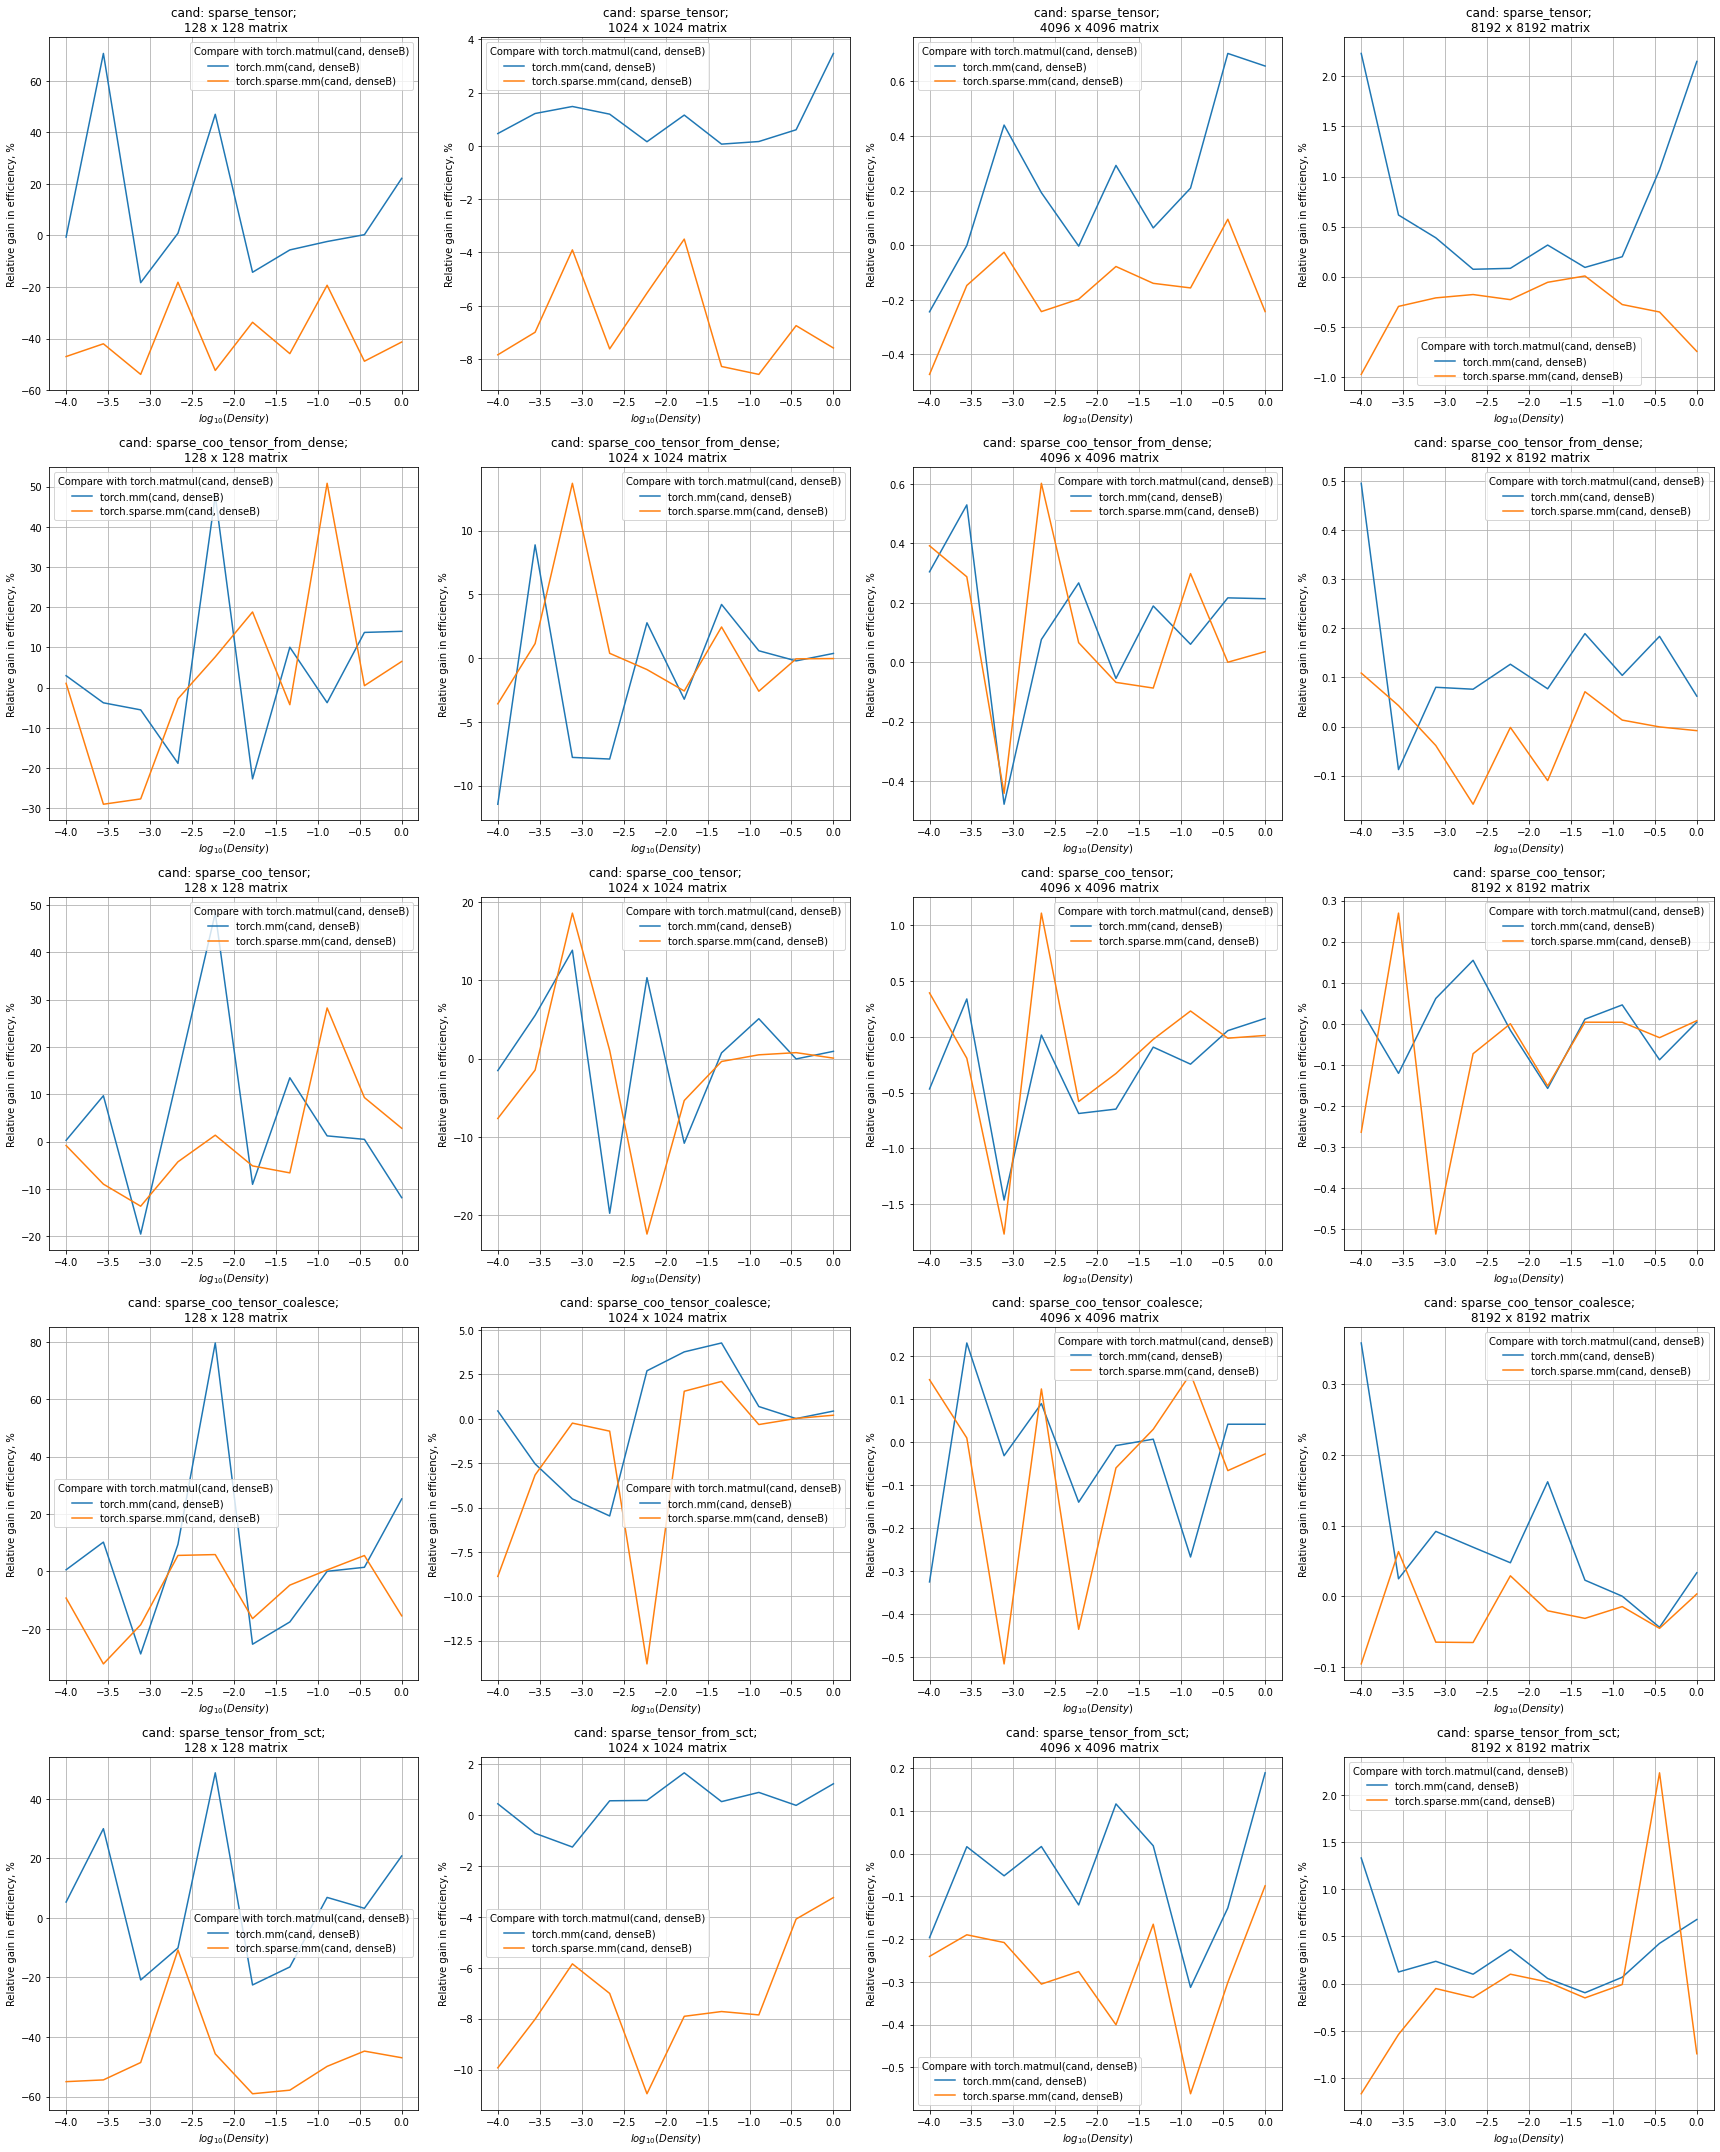

In [66]:
def _plot_comp_tensormethods_vs_sizes_across_tensorops_with_ref(dict_results):
    tensor_ops = list(dict_results.keys())
    tensor_methods = list(dict_results[tensor_ops[0]].keys())
    sizes = list(dict_results[tensor_ops[0]][tensor_methods[0]].keys())
    densities = list(dict_results[tensor_ops[0]][tensor_methods[0]][sizes[0]].keys())
    
    ref_op = 'torch_matmul'
    ref_method = 'dense_tensor'
    tensor_ops.remove(ref_op)
    tensor_methods.remove(ref_method)

    nrows, ncols = len(tensor_methods), len(sizes) + (1 if len(sizes) == 1 else 0)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*6, nrows*6))

    for r, method in enumerate(tensor_methods):
        for c, size in enumerate(sorted(list(map(int, sizes)))):
            size = str(size)
            xvals = np.log10(list(map(float, densities)))
            
            ref_operation = ".".join(ref_op.split("_"))
            ref_vals = np.array(list(map(float, dict_results[ref_op][method][size].values())))
            for op in tensor_ops:
                yvals = np.array(list(map(float, dict_results[op][method][size].values())))
                yvals = (ref_vals / yvals - 1) * 100
                axes[r][c].plot(xvals, yvals, label=f"{'.'.join(op.split('_'))}(cand, denseB)")
            
            # ref_time = np.mean(list(dict_results[ref_op][ref_method][size].values())) * 1000
            # axes[r][c].axline((xvals[0], ref_time), (xvals[1], ref_time), color='k', label="torch.matmul(denseA, denseB)")
            # axes[r][c].text(x=xvals[1], y=ref_time*1.001, s=f"torch.matmul(denseA, denseB)")
            
            axes[r][c].legend(title=f'Compare with {ref_operation}(cand, denseB)')
            axes[r][c].set_title(f'cand: {method};\n {size} x {size} matrix')
            axes[r][c].set_xlabel(r'$log_{10}(Density)$')
            axes[r][c].set_ylabel(f'Relative gain in efficiency, %')
            axes[r][c].grid()
    plt.tight_layout()
    return fig, axes
    
fig, axes = _plot_comp_tensormethods_vs_sizes_across_tensorops_with_ref(dict_results)
fig.savefig(f'{filename.split(".")[0]}_methods_vs_sizes_across_ops_with_ref.png')

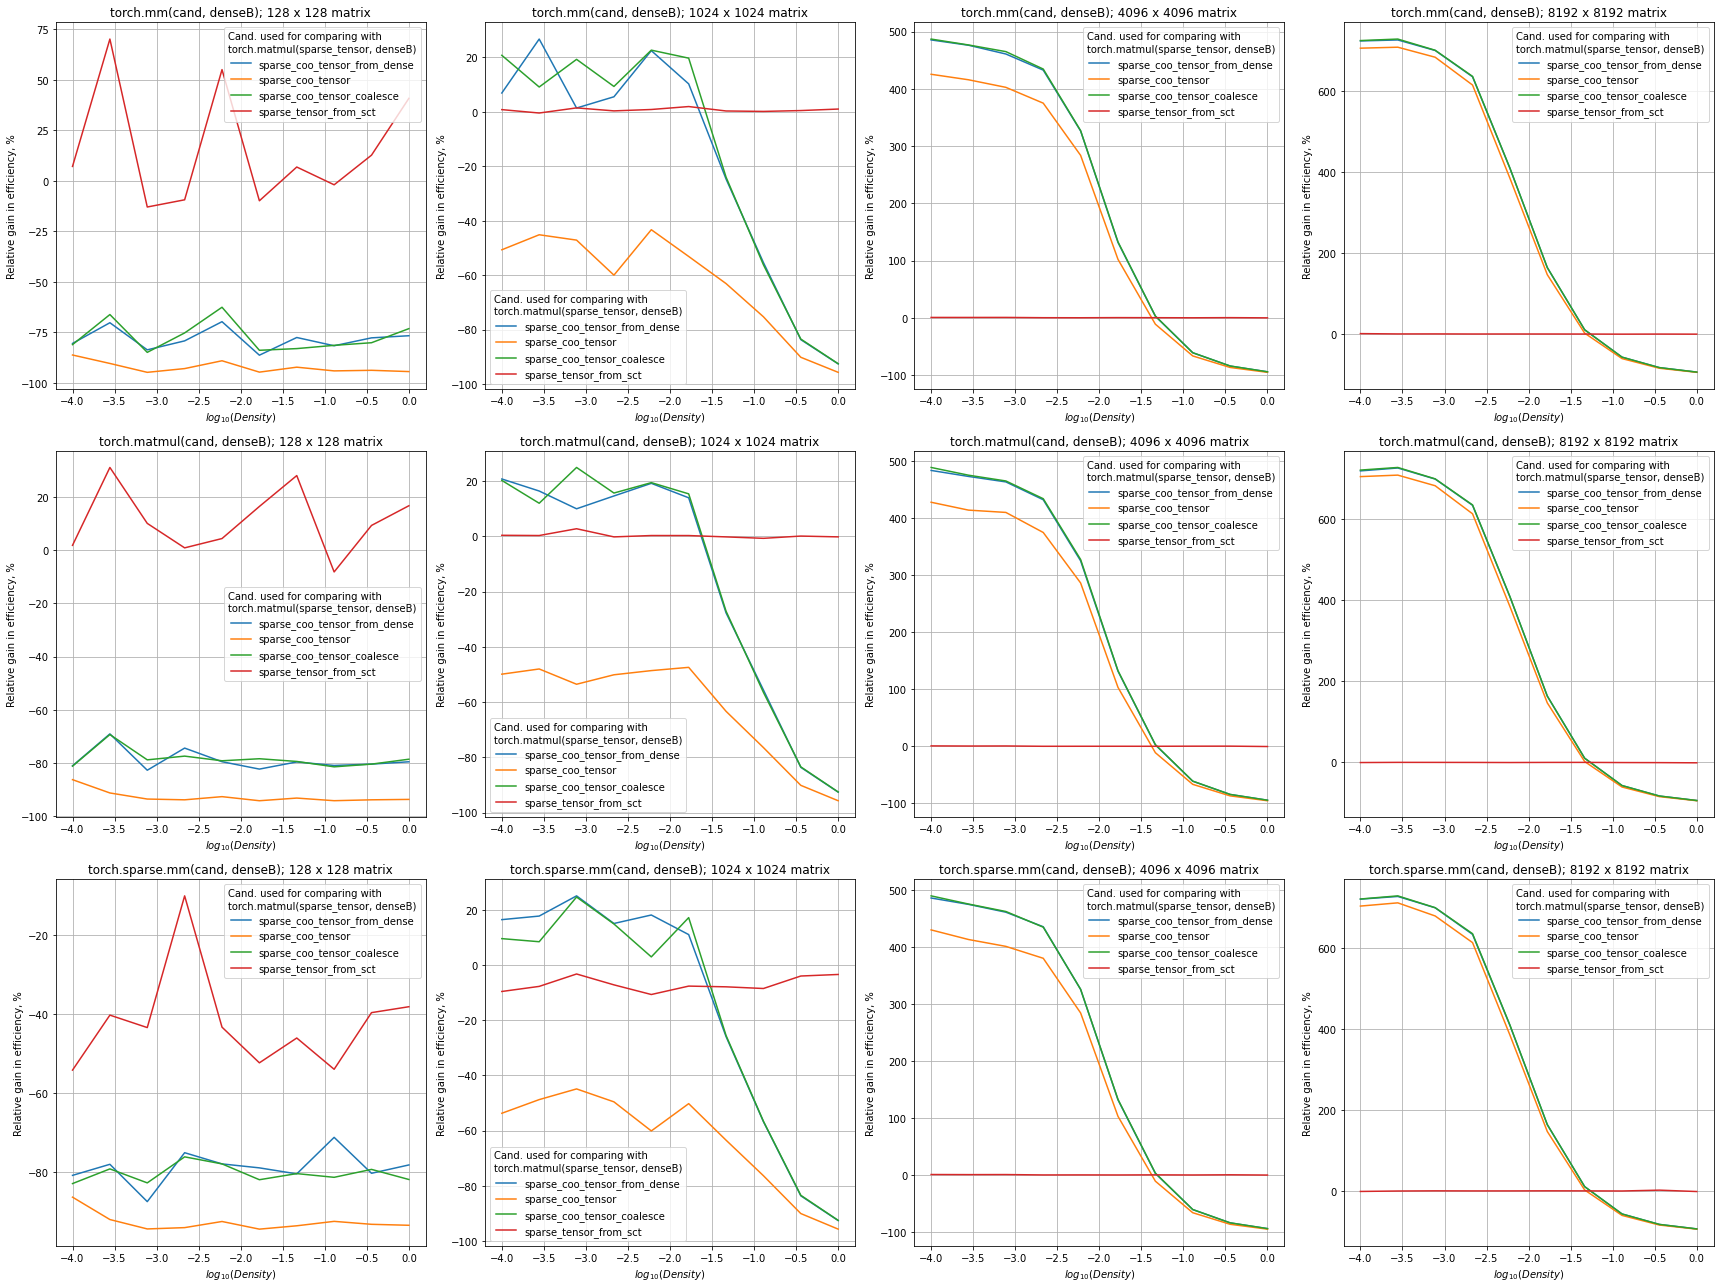

In [68]:
def _plot_comp_tensorops_vs_sizes_across_tensormethods_with_ref(dict_results):
    tensor_ops = list(dict_results.keys())
    tensor_methods = list(dict_results[tensor_ops[0]].keys())
    sizes = list(dict_results[tensor_ops[0]][tensor_methods[0]].keys())
    densities = list(dict_results[tensor_ops[0]][tensor_methods[0]][sizes[0]].keys())
    
    ref_op = 'torch_matmul'
    ref_method = 'sparse_tensor'
    # tensor_ops.remove(ref_op)
    tensor_methods.remove(ref_method)
    tensor_methods.remove('dense_tensor')

    nrows, ncols = len(tensor_ops), len(sizes) + (1 if len(sizes) == 1 else 0)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*6, nrows*6))

    for r, op in enumerate(tensor_ops):
        for c, size in enumerate(sorted(list(map(int, sizes)))):
            size = str(size)
            xvals = np.log10(list(map(float, densities)))
            operation = '.'.join(op.split('_'))
            ref_operation = '.'.join(ref_op.split('_'))
            
            ref_vals = np.array(list(map(float, dict_results[ref_op][ref_method][size].values())))
            # print('-'*8 + 'Reference:' ,ref_op, ref_method, ref_vals)
            
            for method in tensor_methods:
                yvals = np.array(list(map(float, dict_results[op][method][size].values())))
                # print('-'*12, op, method, yvals)
                yvals = (np.divide(ref_vals, yvals) - 1) * 100
                axes[r][c].plot(xvals, yvals, label=f"{method}")
                
            # ref_time = np.mean(list(dict_results[ref_op][ref_method][size].values())) * 1000
            # axes[r][c].axline((xvals[0], ref_time), (xvals[1], ref_time), color='k', label="torch.matmul(denseA, denseB)")
            # axes[r][c].text(x=xvals[1], y=ref_time*1.001, s=f"torch.matmul(denseA, denseB)")
            
            axes[r][c].legend(title=f'Cand. used for comparing with \n{ref_operation}({ref_method}, denseB)')
            axes[r][c].set_title(f'{operation}(cand, denseB); {size} x {size} matrix')
            axes[r][c].set_xlabel(r'$log_{10}(Density)$')
            axes[r][c].set_ylabel(r'Relative gain in efficiency, %')
            axes[r][c].grid()
    plt.tight_layout()
    return fig, axes
    
fig, axes = _plot_comp_tensorops_vs_sizes_across_tensormethods_with_ref(dict_results)
fig.savefig(f'{filename.split(".")[0]}_ops_vs_sizes_across_methods_with_ref.png')

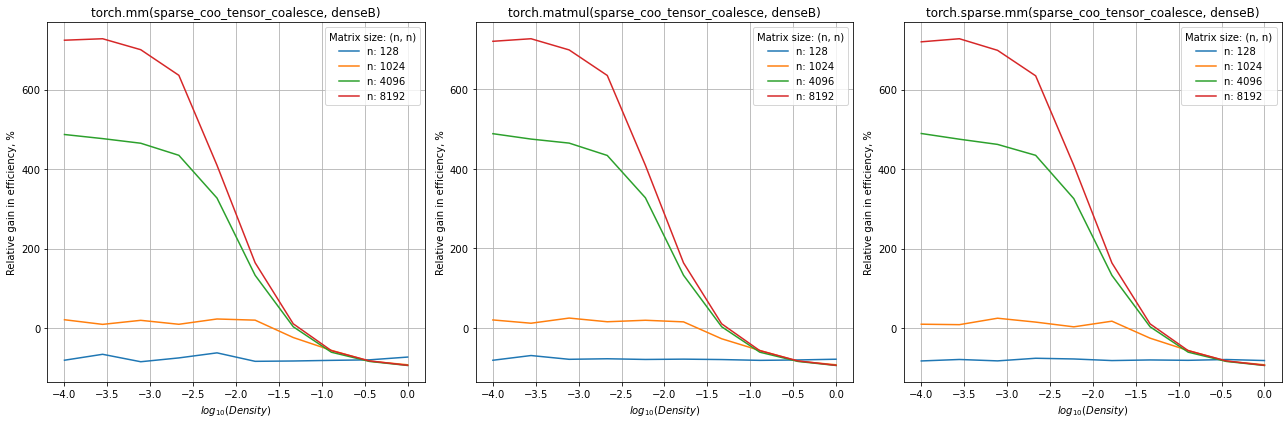

In [77]:
def _plot_comp_tensormethod_with_ref_across_sizes_and_tensorops(dict_results, tensor_method):
    tensor_ops = list(dict_results.keys())
    tensor_methods = list(dict_results[tensor_ops[0]].keys())
    sizes = list(dict_results[tensor_ops[0]][tensor_methods[0]].keys())
    densities = list(dict_results[tensor_ops[0]][tensor_methods[0]][sizes[0]].keys())
    
    ref_op = 'torch_matmul'
    ref_method = 'sparse_tensor'
    # tensor_ops.remove(ref_op)
    tensor_methods.remove(ref_method)
    tensor_methods.remove('dense_tensor')

    nrows, ncols = 1, len(tensor_ops)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*6, nrows*6))
    
    for r, op in enumerate(tensor_ops):
        xvals = np.log10(list(map(float, densities)))
        operation = '.'.join(op.split('_'))
        ref_operation = '.'.join(ref_op.split('_'))
            
        for size in sorted(list(map(int, sizes))):
            size = str(size)
            
            ref_vals = np.array(list(map(float, dict_results[ref_op][ref_method][size].values())))
            # print('-'*8 + 'Reference:' ,ref_op, ref_method, ref_vals)
            
            yvals = np.array(list(map(float, dict_results[op][tensor_method][size].values())))
            # print('-'*12, op, method, yvals)
            yvals = (np.divide(ref_vals, yvals) - 1) * 100
            axes[r].plot(xvals, yvals, label=f"n: {size}")
                
            # ref_time = np.mean(list(dict_results[ref_op][ref_method][size].values())) * 1000
            # axes[r][c].axline((xvals[0], ref_time), (xvals[1], ref_time), color='k', label="torch.matmul(denseA, denseB)")
            # axes[r][c].text(x=xvals[1], y=ref_time*1.001, s=f"torch.matmul(denseA, denseB)")
            
            axes[r].legend(title=f'Matrix size: (n, n)')
            axes[r].set_title(f'{operation}({tensor_method}, denseB)')
            axes[r].set_xlabel(r'$log_{10}(Density)$')
            axes[r].set_ylabel(r'Relative gain in efficiency, %')
            axes[r].grid(True)
    plt.tight_layout()
    return fig, axes
    
fig, axes = _plot_comp_tensormethod_with_ref_across_sizes_and_tensorops(dict_results, 'sparse_coo_tensor_coalesce')
fig.savefig(f'{filename.split(".")[0]}_comp_method_w_ref_across_sizes_and_ops.png')

In [4]:
def _plot_dvs_result(df, title = 'GPU', use_log10 = False):
    font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : 22}

    plt.rcParams.update({'font.size': 16})
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    row_names = list(map(int, list(df.index)))
    row_values = [-val for val in row_names]

    # col_names = list(df.columns)
    # col_names.remove('Unnamed: 0')
    col_names = ['256', '512', '2048', '4096']

    for name in col_names:
        yvals = df.iloc[:][name].values
        if use_log10:
            yvals = np.log10(yvals)
        axes.plot(row_values, yvals, label=name)
    
    axes.legend(title='Size(n) of nxn matrix')
    axes.set_title(title)
    axes.set_xlabel(r'$log_{10}$(Density)')
    ylabel = r'$t_{matmul}\ /\ t_{sparse\_mm}$'
    if use_log10:
        ylabel = r'$log_{10}(t_{matmul}\ /\ t_{sparse\_mm})$'
    axes.set_ylabel(ylabel)
    return fig, axes


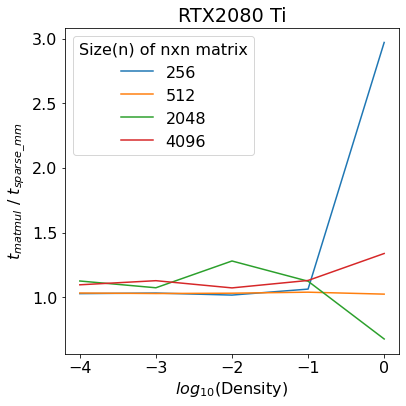

In [5]:
fig, axes = _plot_dvs_result(df_dvs_gpu, 'RTX2080 Ti')

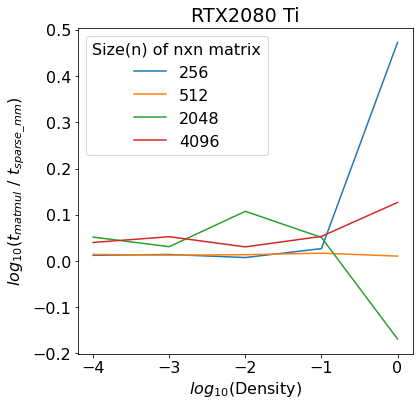

In [6]:
fig, axes = _plot_dvs_result(df_dvs_gpu, 'RTX2080 Ti', True)

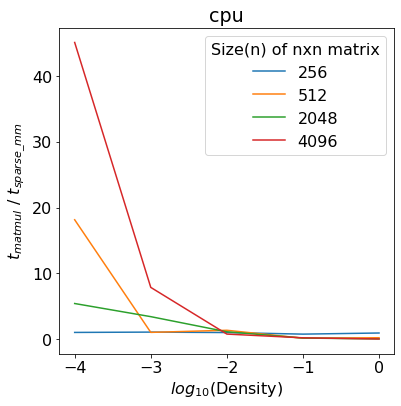

In [82]:
fig, axes = _plot_dvs_result(df_dvs_cpu, 'cpu')

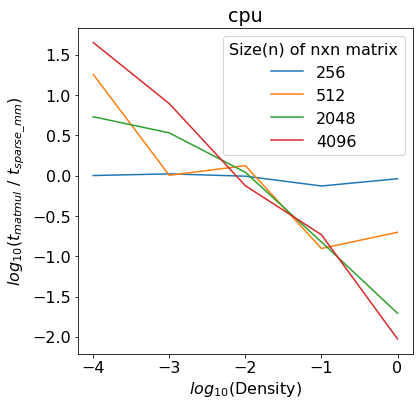

In [84]:
fig, axes = _plot_dvs_result(df_dvs_cpu, 'cpu', True)